In [105]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import GRU
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.resnet_v2 import ResNet152V2, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [106]:
image_path = "../input/flickr-8k-images-with-captions/Images/"
dir_Flickr_text = "../input/flickr8k-text/flickr8k.token.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


In [107]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   pre_col = line.split()
   if len(pre_col) == 0:
       continue
   col = []
   col.append(pre_col[0])
   col.append(' '.join(pre_col[1:]))
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [108]:
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


In [109]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text): 
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [110]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


In [111]:
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [112]:
PATH = "../input/flickr-8k-images-with-captions/Images/"
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['../input/flickr-8k-images-with-captions/Images/1000268201_693b08cb0e.jpg',
 '../input/flickr-8k-images-with-captions/Images/1000268201_693b08cb0e.jpg',
 '../input/flickr-8k-images-with-captions/Images/1000268201_693b08cb0e.jpg',
 '../input/flickr-8k-images-with-captions/Images/1000268201_693b08cb0e.jpg',
 '../input/flickr-8k-images-with-captions/Images/1000268201_693b08cb0e.jpg',
 '../input/flickr-8k-images-with-captions/Images/1001773457_577c3a7d70.jpg',
 '../input/flickr-8k-images-with-captions/Images/1001773457_577c3a7d70.jpg',
 '../input/flickr-8k-images-with-captions/Images/1001773457_577c3a7d70.jpg',
 '../input/flickr-8k-images-with-captions/Images/1001773457_577c3a7d70.jpg',
 '../input/flickr-8k-images-with-captions/Images/1001773457_577c3a7d70.jpg']

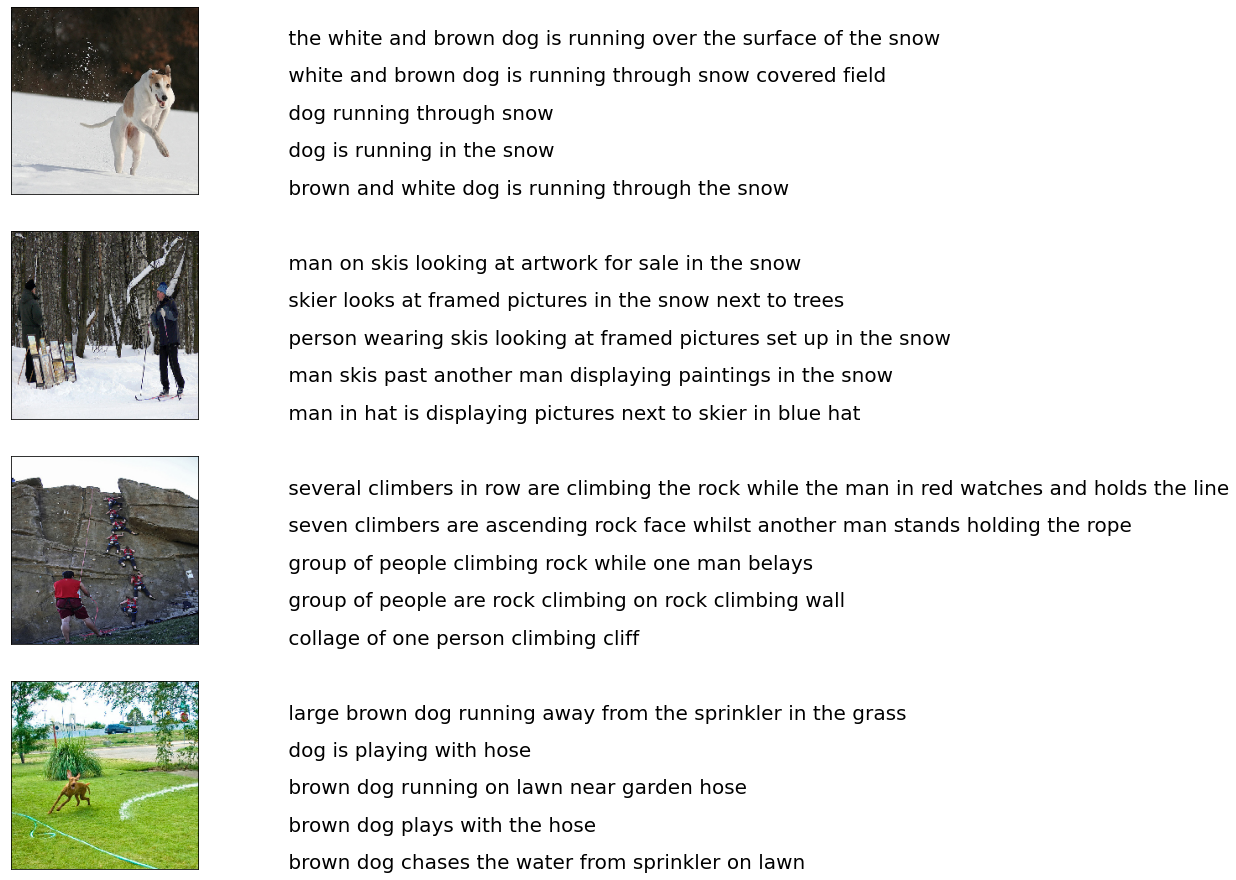

In [113]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [114]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [115]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [116]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = ResNet152V2(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [117]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [118]:
%%time
os.makedirs('/kaggle/flickr_features')
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   path_of_feature = "/kaggle/flickr_features/"+path_of_feature.split('/')[-1]
   np.save(path_of_feature, bf.numpy())

FileExistsError: [Errno 17] File exists: '/kaggle/flickr_features'

In [119]:
top_k = len(clean_vocabulary)
tokenizer = Tokenizer(num_words=top_k,
                      oov_token="<unk>",
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = pad_sequences(train_seqs, padding='post')

In [120]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [121]:
index = 0
for path in img_name_vector:
    img_name_vector[index] = "/kaggle/flickr_features/" + path.split('/')[-1]
    index = index + 1
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [122]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [123]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [124]:
#The advantage of using Glove over Word2Vec is that 
#GloVe does not just rely on the local context of words but it incorporates global word co-occurrence to obtain word vectors
embeddings_index = {} 
f = open('../input/glove840b300dtxt/glove.840B.300d.txt', encoding="utf-8")
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


In [125]:
embedding_dim = len(list(embeddings_index.values())[0])
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [126]:
class ResNet_Encoder(Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(ResNet_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = Dense(embedding_dim)
       self.dropout = Dropout(0.5, noise_shape=None, seed=None)
   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [127]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return CuDNNLSTM(units,
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform')
   else:
       return GRU(units,
                  return_sequences=True,
                  return_state=True,
                  recurrent_activation='sigmoid',
                  recurrent_initializer='glorot_uniform')

In [128]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = Embedding(vocab_size, embedding_dim, trainable=False, weights=[embedding_matrix])
   #self.embedding = Embedding(vocab_size, embedding_dim)
   self.gru = GRU(self.units,
                  return_sequences=True,
                  return_state=True,
                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = Dense(self.units)

   self.dropout = Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = Dense(units)
   self.Wattn = Dense(units)
   self.Vattn = Dense(1)
 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = ResNet_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [129]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [130]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [131]:
EPOCHS = 20
elapsed_start = time.time()
for epoch in range(0, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
print(f'Time taken to train model: {time.time() - elapsed_start} seconds')

Epoch 1 Batch 0 Loss 2.7450
Epoch 1 Batch 100 Loss 1.6618
Epoch 1 Batch 200 Loss 1.3806
Epoch 1 Batch 300 Loss 1.2393
Epoch 1 Batch 400 Loss 1.1832
Epoch 1 Loss 1.387032
Time taken for 1 epoch 93.81690669059753 sec

Epoch 2 Batch 0 Loss 1.0793
Epoch 2 Batch 100 Loss 1.1353
Epoch 2 Batch 200 Loss 1.2144
Epoch 2 Batch 300 Loss 1.0635
Epoch 2 Batch 400 Loss 1.0751
Epoch 2 Loss 1.069154
Time taken for 1 epoch 54.89281988143921 sec

Epoch 3 Batch 0 Loss 0.9503
Epoch 3 Batch 100 Loss 1.0295
Epoch 3 Batch 200 Loss 0.9848
Epoch 3 Batch 300 Loss 1.0238
Epoch 3 Batch 400 Loss 0.8924
Epoch 3 Loss 0.947821
Time taken for 1 epoch 55.49925780296326 sec

Epoch 4 Batch 0 Loss 0.7962
Epoch 4 Batch 100 Loss 0.8255
Epoch 4 Batch 200 Loss 0.7933
Epoch 4 Batch 300 Loss 0.8617
Epoch 4 Batch 400 Loss 0.8709
Epoch 4 Loss 0.854088
Time taken for 1 epoch 55.176766872406006 sec

Epoch 5 Batch 0 Loss 0.8070
Epoch 5 Batch 100 Loss 0.6735
Epoch 5 Batch 200 Loss 0.7450
Epoch 5 Batch 300 Loss 0.7819
Epoch 5 Batch 400

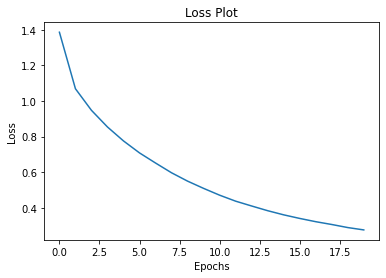

In [132]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [133]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [134]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

In [135]:
index = 0
for path in img_name_val:
    img_name_val[index] = '../input/flickr-8k-images-with-captions/Images/' + path.split('/')[-1]
    index = index + 1

In [142]:
actual = []
predicted =[]
for i in range(100):
    rid = np.random.randint(0, len(img_name_val))
    image = img_name_val[rid]
    start = time.time()
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
    for i in result:
       if i=="<unk>":
           result.remove(i)

#remove <end> from result        
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = result_final

actual.append(real_caption)
predicted.append(result_final)

In [143]:
print(f'BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}')
print(f'BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}')

BLEU-1: 0.38095238095238093
BLEU-2: 0.6172133998483676
